In [3]:
import numpy as np
import random
import warnings

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (accuracy_score)
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Activation, Dense)


warnings.filterwarnings('ignore')
np.random.seed(49)

In [4]:
import numpy as np
import pandas as pd
import random
import os
import re
import string
import warnings
import cv2
import email
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from imutils import paths
from bs4 import BeautifulSoup
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (accuracy_score,recall_score,precision_score, f1_score, confusion_matrix, 
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Activation, 
                                     Flatten, Dense)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

warnings.filterwarnings('ignore')
np.random.seed(49)

In [5]:
import pickle
with open('email_texts.pkl', 'rb') as f:
    email_texts = pickle.load(f)

with open('label_list.pkl', 'rb') as f:
    label_list = pickle.load(f)

print   ("Data loaded from pickle files.")



X_train, X_test, y_train, y_test = train_test_split(email_texts, label_list, test_size=0.1, random_state=42)



Data loaded from pickle files.


In [6]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X_train)

CountVectorizer(stop_words='english')

In [7]:
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)

In [8]:
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

MLP using FL

In [ ]:
def create_clients(email_list, label_list, num_clients=10, initial='clients'):
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    data = list(zip(email_list, label_list))
    random.shuffle(data)
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

In [10]:
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [11]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [12]:
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [13]:
class SimpleMLP:
    @staticmethod
    def build(shape):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))  
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(1))  
        model.add(Activation("sigmoid"))  
        
        return model

In [14]:
loss = 'binary_crossentropy'  
metrics = ['accuracy']

In [15]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names]) * bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() * bs
    return local_count / global_count


def scale_model_weights(weight, scalar):
    scaled_weights = [scalar * w for w in weight]
    return scaled_weights


def sum_scaled_weights(scaled_weight_list):
    avg_grad = [tf.reduce_sum(w, axis=0) for w in zip(*scaled_weight_list)]
    return avg_grad


def test_global_model(X_test, Y_test, model):
    # Predict probabilities for the ROC and AUC calculation
    logits = model.predict(X_test).ravel()  # Flatten for ROC curve

    # Calculate binary cross-entropy loss
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    loss = loss_fn(Y_test, logits).numpy()
    
    # Calculate accuracy
    acc = accuracy_score((logits > 0.5).astype(int), Y_test)

    rec = recall_score((logits > 0.5).astype(int), Y_test)

    pre = precision_score((logits > 0.5).astype(int), Y_test)

    # Calculate AUC score
    auc = roc_auc_score(Y_test, logits)

    # Generate ROC curve data
    fpr, tpr, thresholds = roc_curve(Y_test, logits)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Final Global Model")
    plt.legend(loc="lower right")
    plt.show()

    # Print performance metrics
    print(f'Final Global Model | Accuracy: {acc:.3%} | Loss: {loss:.4f} | AUC: {auc:.3f}')
    
    return acc, loss, auc




14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


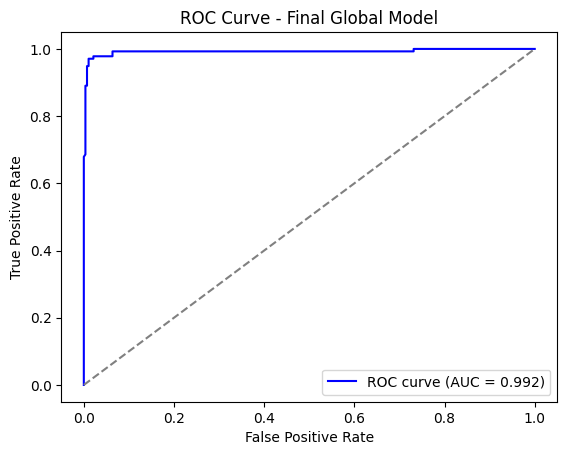

Final Global Model | Accuracy: 98.333% | Loss: 0.1052 | AUC: 0.992


In [16]:

smlp_global = SimpleMLP()
global_model = smlp_global.build(34765)  
global_model.compile(loss=loss, metrics=metrics)

 
# Run communication rounds
comms_round = 10  
for comm_round in range(comms_round):
    
    global_weights = global_model.get_weights()
    scaled_local_weight_list = []

    client_names = list(clients_batched.keys())
    random.shuffle(client_names)
    
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(34765)  
        local_model.compile(loss=loss, metrics=metrics)
        
        local_model.set_weights(global_weights)
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
    
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)


for (X_test, Y_test) in test_batched:
    final_acc, final_loss, final_auc = test_global_model(X_test, Y_test, global_model)


In [17]:
def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

KNN using FL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_features = vectorizer.fit_transform(email_texts)
X_train, X_test, y_train, y_test = train_test_split(X_features, label_list, test_size=0.1, random_state=42)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of KNN model: {accuracy}')


Accuracy of KNN model: 0.7047619047619048


In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train_dense = X_train.toarray()
clients = 3
communication_rounds=10
X_train_splits = np.array_split(X_train_dense, clients)
y_train_splits = np.array_split(y_train, clients)
client_models = [KNeighborsClassifier(n_neighbors=10) for _ in range(clients)]

for i in range(clients):
    client_models[i].fit(X_train_splits[i], y_train_splits[i])


In [ ]:
from scipy.stats import mode
def federated_knn_predict(X_test, client_models):
    client_predictions = []
    for model in client_models:
        client_predictions.append(model.predict(X_test))
    
    client_predictions = np.array(client_predictions)
    final_predictions, _ = mode(client_predictions, axis=0)
    
    return final_predictions.ravel()

In [ ]:

for comm_round in range(1, communication_rounds + 1):
    global_predictions = federated_knn_predict(X_test, client_models)
    global_accuracy = accuracy_score(y_test, global_predictions)
    print(f'Communication Round {comm_round} | Federated KNN (majority voting) Accuracy: {global_accuracy:.3%}')

Communication Round 1 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 2 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 3 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 4 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 5 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 6 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 7 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 8 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 9 | Federated KNN (majority voting) Accuracy: 60.952%
Communication Round 10 | Federated KNN (majority voting) Accuracy: 60.952%


Accuracy: 0.610
Precision: 0.454
Recall: 0.971
F1 Score: 0.619
AUC: 0.844


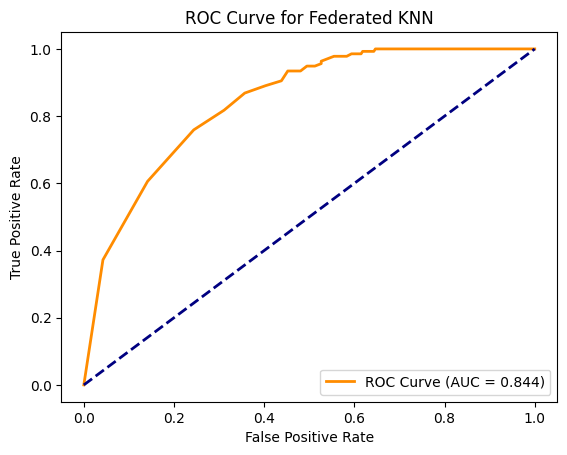

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import mode

# Get predictions from each client
client_predictions = []
client_probabilities = []
for model in client_models:
    client_predictions.append(model.predict(X_test))
    client_probabilities.append(model.predict_proba(X_test)[:, 1])  # Probability for positive class

# Majority voting for final predictions
client_predictions = np.array(client_predictions)
final_predictions, _ = mode(client_predictions, axis=0)
final_predictions = final_predictions.ravel()

# Average probabilities for final ROC calculation
client_probabilities = np.array(client_probabilities)
avg_probabilities = np.mean(client_probabilities, axis=0)

# Calculate metrics
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)
roc_auc = roc_auc_score(y_test, avg_probabilities)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {roc_auc:.3f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, avg_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Federated KNN')
plt.legend(loc="lower right")
plt.show()


SVM using FL

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TfidfVectorizer instance
vectorizer = TfidfVectorizer()
X_features = vectorizer.fit_transform(email_texts)
X_train, X_test, y_train, y_test = train_test_split(X_features, label_list, test_size=0.1, random_state=42)


In [ ]:
# Define the number of clients
num_clients = 5
num_rounds=10

def split_data(X, y, num_clients):
    data_per_client = X.shape[0] // num_clients  
    clients_data = []
    for i in range(num_clients):
        start_idx = i * data_per_client
        end_idx = (i + 1) * data_per_client
        clients_data.append((X[start_idx:end_idx], y[start_idx:end_idx]))
    return clients_data

clients_data = split_data(X_train, y_train, num_clients)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def train_local_svm(client_data):
    X_client, y_client = client_data
    model = svm.SVC(kernel='linear', probability=True)  
    model.fit(X_client, y_client.ravel())  
    return model

global_accuracies = []
global_precisions = []
global_recalls = []
global_f1_scores = []
global_aucs = []

for round_num in range(num_rounds):
    # Train local SVM models for each client
    local_models = [train_local_svm(data) for data in clients_data]
    aggregated_probabilities = np.zeros((X_test.shape[0], 2))
    
    for model in local_models:
        client_probabilities = model.predict_proba(X_test)  
        aggregated_probabilities += client_probabilities
    
    aggregated_probabilities /= num_clients
    y_pred = np.argmax(aggregated_probabilities, axis=1)  # Get the class with highest probability

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    auc=roc_auc_score(y_test,aggregated_probabilities[:,1])

    global_accuracies.append(accuracy)
    global_precisions.append(precision)
    global_recalls.append(recall)
    global_f1_scores.append(f1)
    global_aucs.append(auc)
    
    print(f"Round {round_num+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Calculate average metrics across rounds
avg_global_accuracy = np.mean(global_accuracies)
avg_global_precision = np.mean(global_precisions)
avg_global_recall = np.mean(global_recalls)
avg_global_f1 = np.mean(global_f1_scores)
avg_global_auc = np.mean(global_aucs)

print(f"\nAverage Global Metrics Across Rounds - Accuracy: {avg_global_accuracy:.4f}, Precision: {avg_global_precision:.4f}, Recall: {avg_global_recall:.4f}, F1-Score: {avg_global_f1:.4f}, AUC: {avg_global_auc:.4f}")


Round 1 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 2 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 3 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 4 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 5 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 6 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 7 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 8 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 9 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328
Round 10 - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328

Average Global Metrics Across Rounds - Accuracy: 0.9571, Precision: 0.9542, Recall: 0.9124, F1-Score: 0.9328, AUC: 0.9953


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for i, model in enumerate(local_models):
    y_pred = model.predict(X_test) 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Local Model {i+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Local Model 1 - Accuracy: 0.9476, Precision: 0.9832, Recall: 0.8540, F1-Score: 0.9141
Local Model 2 - Accuracy: 0.9405, Precision: 0.9828, Recall: 0.8321, F1-Score: 0.9012
Local Model 3 - Accuracy: 0.9476, Precision: 0.9675, Recall: 0.8686, F1-Score: 0.9154
Local Model 4 - Accuracy: 0.9429, Precision: 0.9669, Recall: 0.8540, F1-Score: 0.9070
Local Model 5 - Accuracy: 0.9548, Precision: 0.9917, Recall: 0.8686, F1-Score: 0.9261


Average Metrics Across Local Models - Accuracy: 0.9467, Precision: 0.9784, Recall: 0.8555, F1-Score: 0.9127, AUC: 0.9946


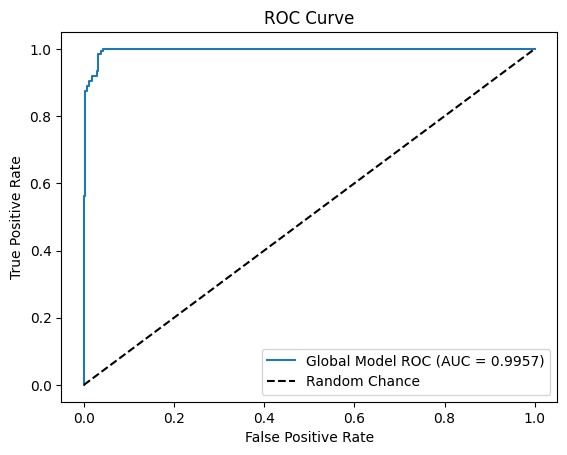

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from scipy.sparse import issparse  

total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
total_auc = 0  

for model in local_models:
    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)  

    total_accuracy += accuracy_score(y_test, y_pred)
    total_precision += precision_score(y_test, y_pred, average='binary')
    total_recall += recall_score(y_test, y_pred, average='binary')
    total_f1 += f1_score(y_test, y_pred, average='binary')
    
    auc = roc_auc_score(y_test, y_score)
    total_auc += auc


coef_list = []
intercept_list = []

for model in local_models:
    # Convert sparse coefficients to dense format if needed
    coef = model.coef_.toarray() if issparse(model.coef_) else model.coef_
    coef_list.append(coef)
    intercept_list.append(model.intercept_)

coef_array = np.array(coef_list)
intercept_array = np.array(intercept_list)

# Average the coefficients and intercepts across all local models
avg_coef = np.mean(coef_array, axis=0)
avg_intercept = np.mean(intercept_array, axis=0)

# Create a new global SVM model with dummy data
global_model = svm.LinearSVC() 
global_model.fit(np.zeros((2, avg_coef.shape[1])), [0, 1]) 

global_model.coef_ = avg_coef  
global_model.intercept_ = avg_intercept

# Calculate average metrics
avg_accuracy = total_accuracy / len(local_models)
avg_precision = total_precision / len(local_models)
avg_recall = total_recall / len(local_models)
avg_f1 = total_f1 / len(local_models)
avg_auc = total_auc / len(local_models)  

print(f"Average Metrics Across Local Models - Accuracy: {avg_accuracy:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}, AUC: {avg_auc:.4f}")

# Plot ROC curve using the final global model
y_score_global = global_model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score_global)

plt.figure()
plt.plot(fpr, tpr, label=f'Global Model ROC (AUC = {roc_auc_score(y_test, y_score_global):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Logistic regression

Round 1 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
Round 2 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
Round 3 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
Round 4 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
Round 5 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
Round 6 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
Round 7 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
Round 8 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
Round 9 - Global Aggregated Accuracy: 0.9143, Precision: 0.9903, Recall: 0.7445, F1-Score: 0.8500, AUC: 0.9928
R

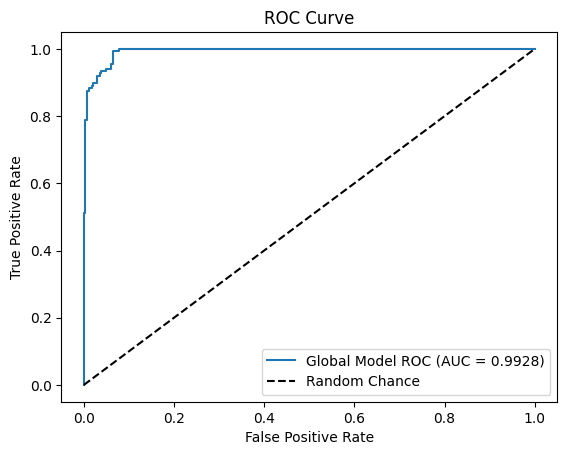

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone

num_rounds = 10
num_clients = 5

global_accuracies = []
global_precisions = []
global_recalls = []
global_f1_scores = []
global_aucs = []

global_model = LogisticRegression(solver='liblinear')

# Dummy data to initialize global model with two classes
dummy_X = np.array([[0] * X_test.shape[1], [1] * X_test.shape[1]])
dummy_y = np.array([0, 1]) 
global_model.fit(dummy_X, dummy_y) 

def average_model_weights(models):
    coef = np.mean([model.coef_ for model in models], axis=0)
    intercept = np.mean([model.intercept_ for model in models], axis=0)
    return coef, intercept

def train_local_logistic_regression(client_data, global_model):
    X_client, y_client = client_data
    
    local_model = clone(global_model)
    local_model.fit(X_client, y_client)
    return local_model

for round_num in range(num_rounds):

    local_models = [train_local_logistic_regression(data, global_model) for data in clients_data]
    avg_coef, avg_intercept = average_model_weights(local_models)
    global_model.coef_ = avg_coef
    global_model.intercept_ = avg_intercept

    aggregated_probabilities = global_model.predict_proba(X_test)
    y_pred = np.argmax(aggregated_probabilities, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, aggregated_probabilities[:, 1])  

    # Append metrics for analysis
    global_accuracies.append(accuracy)
    global_precisions.append(precision)
    global_recalls.append(recall)
    global_f1_scores.append(f1)
    global_aucs.append(auc)

    print(f"Round {round_num+1} - Global Aggregated Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {auc:.4f}")

# Calculate average metrics across rounds
avg_global_accuracy = np.mean(global_accuracies)
avg_global_precision = np.mean(global_precisions)
avg_global_recall = np.mean(global_recalls)
avg_global_f1 = np.mean(global_f1_scores)
avg_global_auc = np.mean(global_aucs)

print(f"\nAverage Global Metrics Across Rounds - Accuracy: {avg_global_accuracy:.4f}, Precision: {avg_global_precision:.4f}, Recall: {avg_global_recall:.4f}, F1-Score: {avg_global_f1:.4f}, AUC: {avg_global_auc:.4f}")

# Plot ROC curve 
fpr, tpr, _ = roc_curve(y_test, aggregated_probabilities[:, 1])
plt.figure()
plt.plot(fpr, tpr, label=f'Global Model ROC (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Naive bayes

Local Model 1 - Accuracy: 0.8143, Precision: 1.0000, Recall: 0.4307, F1-Score: 0.6020
Local Model 2 - Accuracy: 0.8619, Precision: 1.0000, Recall: 0.5766, F1-Score: 0.7315
Local Model 3 - Accuracy: 0.8429, Precision: 1.0000, Recall: 0.5182, F1-Score: 0.6827
Local Model 4 - Accuracy: 0.8810, Precision: 1.0000, Recall: 0.6350, F1-Score: 0.7768
Local Model 5 - Accuracy: 0.8905, Precision: 1.0000, Recall: 0.6642, F1-Score: 0.7982


Round 1 - Global Model - Accuracy: 0.8619, Precision: 1.0000, Recall: 0.5766, F1-Score: 0.7315, AUC: 0.9949
Round 2 - Global Model - Accuracy: 0.8619, Precision: 1.0000, Recall: 0.5766, F1-Score: 0.7315, AUC: 0.9949
Round 3 - Global Model - Accuracy: 0.8619, Precision: 1.0000, Recall: 0.5766, F1-Score: 0.7315, AUC: 0.9949
Round 4 - Global Model - Accuracy: 0.8619, Precision: 1.0000, Recall: 0.5766, F1-Score: 0.7315, AUC: 0.9949
Round 5 - Global Model - Accuracy: 0.8619, Precision: 1.0000, Recall: 0.5766, F1-Score: 0.7315, AUC: 0.9949
Round 6 - Global Model - Acc

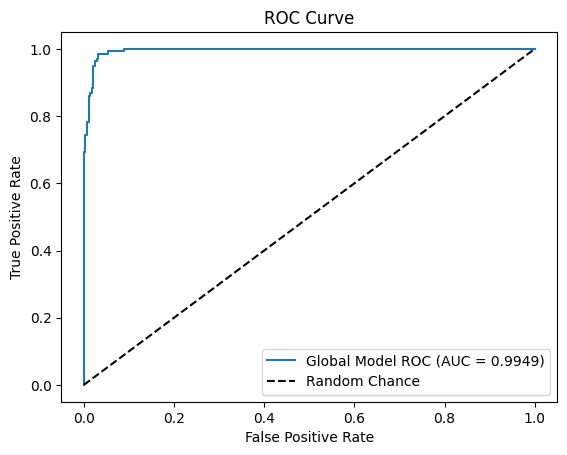

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Define a function to train a Multinomial Naive Bayes model on each client's data
def train_local_naive_bayes(client_data):
    X_client, y_client = client_data
    model = MultinomialNB()
    model.fit(X_client, y_client)
    return model

# Train a local Naive Bayes model for each client
local_models = [train_local_naive_bayes(data) for data in clients_data]

# Function to get averaged predictions across local models
def aggregate_probabilities(local_models, X):

    total_prob = np.zeros((X.shape[0], 2))  
    for model in local_models:
        total_prob += model.predict_proba(X)
    avg_prob = total_prob / len(local_models)
    return avg_prob


avg_prob_test = aggregate_probabilities(local_models, X_test)
y_pred = np.argmax(avg_prob_test, axis=1)  
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, avg_prob_test[:, 1])  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Loop through each local model and calculate metrics
for i, model in enumerate(local_models):
    y_pred = model.predict(X_test)  #
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate precision
    precision = precision_score(y_test, y_pred)
    
    # Calculate recall
    recall = recall_score(y_test, y_pred)
    
    # Calculate F1-score
    f1 = f1_score(y_test, y_pred)
    
    print(f"Local Model {i+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

global_accuracies = []
global_precisions = []
global_recalls = []
global_f1_scores = []
global_aucs = []


print("\n")
# Loop through each communication round
for round_num in range(num_rounds):
    
    local_models = [train_local_naive_bayes(data) for data in clients_data]
    
    # Aggregate local predictions and calculate metrics for the global model
    avg_prob_test = aggregate_probabilities(local_models, X_test)  
    y_pred_global = np.argmax(avg_prob_test, axis=1)
    
    # Calculate global metrics based on aggregated predictions
    accuracy = accuracy_score(y_test, y_pred_global)
    precision = precision_score(y_test, y_pred_global, average='binary')
    recall = recall_score(y_test, y_pred_global, average='binary')
    f1 = f1_score(y_test, y_pred_global, average='binary')
    auc = roc_auc_score(y_test, avg_prob_test[:, 1])  
    
    # Append round metrics to calculate average later
    global_accuracies.append(accuracy)
    global_precisions.append(precision)
    global_recalls.append(recall)
    global_f1_scores.append(f1)
    global_aucs.append(auc)
    
    print(f"Round {round_num+1} - Global Model - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {auc:.4f}")

# Calculate the average metrics across all rounds
avg_global_accuracy = np.mean(global_accuracies)
avg_global_precision = np.mean(global_precisions)
avg_global_recall = np.mean(global_recalls)
avg_global_f1 = np.mean(global_f1_scores)
avg_global_auc = np.mean(global_aucs)

print(f"\nAverage Global Model Metrics Across Rounds - Accuracy: {avg_global_accuracy:.4f}, Precision: {avg_global_precision:.4f}, Recall: {avg_global_recall:.4f}, F1-Score: {avg_global_f1:.4f}, AUC: {avg_global_auc:.4f}")

# Plot ROC curve using the final round's aggregated global model
fpr, tpr, _ = roc_curve(y_test, avg_prob_test[:, 1])

plt.figure()
plt.plot(fpr, tpr, label=f'Global Model ROC (AUC = {avg_global_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()